```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search V: Correlated Wage Offers

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon jax

## Overview

In this lecture we solve a {doc}`McCall style job search model <mccall_model>` with persistent and
transitory components to wages.

In other words, we relax the unrealistic assumption that randomness in wages is independent over time.

At the same time, we will go back to assuming that jobs are permanent and no separation occurs.

This is to keep the model relatively simple as we study the impact of correlation.

We will use the following imports:

In [2]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
import quantecon as qe
from typing import NamedTuple

## The model

Wages at each point in time are given by

$$
w_t = \exp(z_t) + y_t
$$

where

$$
y_t \sim \exp(\mu + s \zeta_t)
\quad \text{and} \quad
z_{t+1} = d + \rho z_t + \sigma \epsilon_{t+1}
$$

Here $\{ \zeta_t \}$ and $\{ \epsilon_t \}$ are both IID and standard normal.

Here $\{y_t\}$ is a transitory component and $\{z_t\}$ is persistent.

As before, the worker can either

1. accept an offer and work permanently at that wage, or
1. take unemployment compensation $c$ and wait till next period.

The value function satisfies the Bellman equation

$$
v^*(w, z) =
    \max
    \left\{
        \frac{u(w)}{1-\beta}, u(c) + \beta \, \mathbb E_z v^*(w', z')
    \right\}
$$

In this expression, $u$ is a utility function and $\mathbb E_z$ is expectation of next period variables given current $z$.

The variable $z$ enters as a state in the Bellman equation because its current value helps predict future wages.

### A simplification

There is a way that we can reduce dimensionality in this problem, which greatly accelerates computation.

To start, let $f^*$ be the continuation value function, defined
by

$$
f^*(z) := u(c) + \beta \, \mathbb E_z v^*(w', z')
$$

The Bellman equation can now be written

$$
v^*(w, z) = \max \left\{ \frac{u(w)}{1-\beta}, \, f^*(z) \right\}
$$

Combining the last two expressions, we see that the continuation value
function satisfies

$$
f^*(z) = u(c) + \beta \, \mathbb E_z \max \left\{ \frac{u(w')}{1-\beta}, f^*(z') \right\}
$$

We’ll solve this functional equation for $f^*$ by introducing the
operator

$$
Qf(z) = u(c) + \beta \, \mathbb E_z \max \left\{ \frac{u(w')}{1-\beta}, f(z') \right\}
$$

By construction, $f^*$ is a fixed point of $Q$, in the sense that
$Q f^* = f^*$.

Under mild assumptions, it can be shown that $Q$ is a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping) over a suitable space of continuous functions on $\mathbb R$.

By Banach's contraction mapping theorem, this means that $f^*$ is the unique fixed point and we can calculate it by iterating with $Q$ from any reasonable initial condition.

Once we have $f^*$, we can solve the search problem by stopping when the reward for accepting exceeds the continuation value, or

$$
\frac{u(w)}{1-\beta} \geq f^*(z)
$$

For utility we take $u(c) = \ln(c)$.

The reservation wage is the wage where equality holds in the last expression.

That is,

```{math}
:label: corr_mcm_barw

\bar w (z) := \exp(f^*(z) (1-\beta))
```

Our main aim is to solve for the reservation rule and study its properties and implications.

## Implementation

Let $f$ be our initial guess of $f^*$.

When we iterate, we use the {doc}`fitted value function iteration <mccall_fitted_vfi>` algorithm.

In particular, $f$ and all subsequent iterates are stored as a vector of values on a grid.

These points are interpolated into a function as required, using piecewise linear interpolation.

The integral in the definition of $Qf$ is calculated by Monte Carlo.

Here's a `NamedTuple` that stores the model parameters and data.

Default parameter values are embedded in the model.

In [3]:
class JobSearchModel(NamedTuple):
    μ: float     # transient shock log mean
    s: float     # transient shock log variance  
    d: float     # shift coefficient of persistent state
    ρ: float     # correlation coefficient of persistent state
    σ: float     # state volatility
    β: float     # discount factor
    c: float     # unemployment compensation
    z_grid: jnp.ndarray 
    e_draws: jnp.ndarray

def create_job_search_model(μ=0.0, s=1.0, d=0.0, ρ=0.9, σ=0.1, β=0.98, c=5.0, 
                           mc_size=1000, grid_size=100, key=jr.PRNGKey(1234)):
    """
    Create a JobSearchModel with computed grid and draws.
    """
    # Set up grid
    z_mean = d / (1 - ρ)
    z_sd = σ / jnp.sqrt(1 - ρ**2)
    k = 3  # std devs from mean
    a, b = z_mean - k * z_sd, z_mean + k * z_sd
    z_grid = jnp.linspace(a, b, grid_size)

    # Draw and store shocks
    e_draws = jr.normal(key, (2, mc_size))

    return JobSearchModel(μ=μ, s=s, d=d, ρ=ρ, σ=σ, β=β, c=c, 
                         z_grid=z_grid, e_draws=e_draws)

Next we implement the $Q$ operator.

In [4]:
def Q(model, f_in):
    """
    Apply the operator Q.

        * model is an instance of JobSearchModel
        * f_in is an array that represents f
        * returns Qf

    """
    μ, s, d = model.μ, model.s, model.d
    ρ, σ, β, c = model.ρ, model.σ, model.β, model.c
    z_grid, e_draws = model.z_grid, model.e_draws
    M = e_draws.shape[1]

    def compute_expectation(z):
        def evaluate_shock(e):
            e1, e2 = e[0], e[1]
            z_next = d + ρ * z + σ * e1
            go_val = jnp.interp(z_next, z_grid, f_in)  # f(z')
            y_next = jnp.exp(μ + s * e2)               # y' draw
            w_next = jnp.exp(z_next) + y_next          # w' draw
            stop_val = jnp.log(w_next) / (1 - β)
            return jnp.maximum(stop_val, go_val)
        
        expectations = jax.vmap(evaluate_shock)(e_draws.T)
        return jnp.mean(expectations)

    expectations = jax.vmap(compute_expectation)(z_grid)
    f_out = jnp.log(c) + β * expectations
    return f_out

Here's a function to compute an approximation to the fixed point of $Q$.

In [5]:
@jax.jit  
def compute_fixed_point(model, tol=1e-4, max_iter=1000):
    """
    Compute an approximation to the fixed point of Q.
    """
    
    def cond_fun(loop_state):
        f, i, error = loop_state
        return jnp.logical_and(error > tol, i < max_iter)
    
    def body_fun(loop_state):
        f, i, error = loop_state
        f_new = Q(model, f)
        error_new = jnp.max(jnp.abs(f_new - f))
        return f_new, i + 1, error_new
    
    # Initial state
    f_init = jnp.full(len(model.z_grid), jnp.log(model.c))
    init_state = (f_init, 0, tol + 1)
    
    # Run iteration
    f_final, iterations, final_error = jax.lax.while_loop(
        cond_fun, body_fun, init_state
    )
    
    return f_final

Let's try generating an instance and solving the model.

In [6]:
model = create_job_search_model()

with qe.Timer():
    f_star = compute_fixed_point(model).block_until_ready()

0.47 seconds elapsed


Next we will compute and plot the reservation wage function defined in {eq}`corr_mcm_barw`.

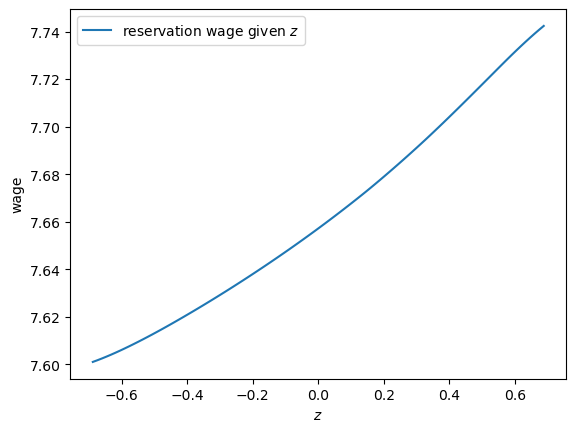

In [7]:
res_wage_function = jnp.exp(f_star * (1 - model.β))

fig, ax = plt.subplots()
ax.plot(
    model.z_grid, res_wage_function, label="reservation wage given $z$"
)
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

Notice that the reservation wage is increasing in the current state $z$.

This is because a higher state leads the agent to predict higher future wages,
increasing the option value of waiting.

Let's try changing unemployment compensation and look at its impact on the
reservation wage:

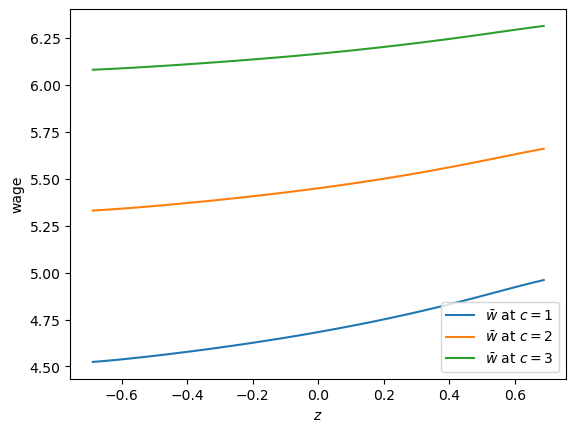

In [8]:
c_vals = 1, 2, 3

fig, ax = plt.subplots()

for c in c_vals:
    model = create_job_search_model(c=c)
    f_star = compute_fixed_point(model)
    res_wage_function = jnp.exp(f_star * (1 - model.β))
    ax.plot(model.z_grid, res_wage_function, 
                label=rf"$\bar w$ at $c = {c}$")

ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

As expected, higher unemployment compensation shifts the reservation wage up
at all state values.

## Unemployment duration

Next we study how mean unemployment duration varies with unemployment compensation.

For simplicity we’ll fix the initial state at $z_t = 0$.

In [9]:
def compute_unemployment_duration(
        model, key=jr.PRNGKey(1234), num_reps=100_000
    ):
    """
    Compute expected unemployment duration.

    """
    f_star = compute_fixed_point(model)
    μ, s, d = model.μ, model.s, model.d
    ρ, σ, β, c = model.ρ, model.σ, model.β, model.c
    z_grid = model.z_grid

    @jax.jit
    def f_star_function(z):
        return jnp.interp(z, z_grid, f_star)

    @jax.jit
    def draw_τ(key, t_max=10_000):
        def cond_fun(loop_state):
            z, t, unemployed, key = loop_state
            return jnp.logical_and(unemployed, t < t_max)
        
        def body_fun(loop_state):
            z, t, unemployed, key = loop_state
            key1, key2, key = jr.split(key, 3)
            
            # Draw current wage
            y = jnp.exp(μ + s * jr.normal(key1))
            w = jnp.exp(z) + y
            res_wage = jnp.exp(f_star_function(z) * (1 - β))
            
            # Check if optimal to stop
            accept = w >= res_wage
            τ = jnp.where(accept, t, t_max)
            
            # Update state if not accepting
            z_new = jnp.where(accept, z, 
                                ρ * z + d + σ * jr.normal(key2))
            t_new = t + 1
            unemployed_new = jnp.logical_not(accept)
            
            return z_new, t_new, unemployed_new, key
        
        # Initial loop_state: (z, t, unemployed, key)
        init_state = (0.0, 0, True, key)
        z_final, t_final, unemployed_final, _ = jax.lax.while_loop(
            cond_fun, body_fun, init_state)
        
        # Return final time if job found, otherwise t_max
        return jnp.where(unemployed_final, t_max, t_final)

    # Generate keys for all simulations
    keys = jr.split(key, num_reps)
    
    # Vectorize over simulations
    τ_vals = jax.vmap(draw_τ)(keys)
    
    return jnp.mean(τ_vals)

Let's test this out with some possible values for unemployment compensation.

In [10]:
c_vals = jnp.linspace(1.0, 10.0, 8)
durations = []
for i, c in enumerate(c_vals):
    model = create_job_search_model(c=c)
    τ = compute_unemployment_duration(model, num_reps=10_000)
    durations.append(τ)
durations = jnp.array(durations)

Here is a plot of the results.

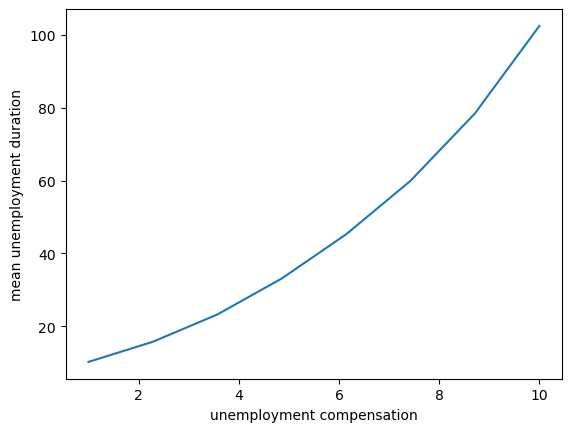

In [11]:
fig, ax = plt.subplots()
ax.plot(c_vals, durations)
ax.set_xlabel("unemployment compensation")
ax.set_ylabel("mean unemployment duration")
plt.show()

Not surprisingly, unemployment duration increases when unemployment compensation is higher.

This is because the value of waiting increases with unemployment compensation.

## Exercises

```{exercise}
:label: mc_ex1

Investigate how mean unemployment duration varies with the discount factor $\beta$.

* What is your prior expectation?
* Do your results match up?
```

```{solution-start} mc_ex1
:class: dropdown
```

Here is one solution

In [12]:
beta_vals = jnp.linspace(0.94, 0.99, 8)
durations = []
for i, β in enumerate(beta_vals):
    model = create_job_search_model(β=β)
    τ = compute_unemployment_duration(model, num_reps=10_000)
    durations.append(τ)
durations = jnp.array(durations)

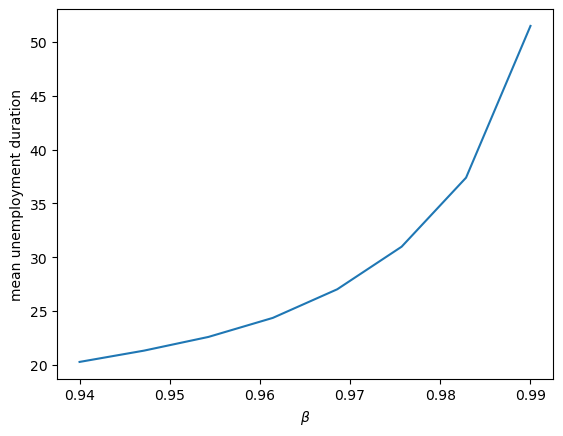

In [13]:
fig, ax = plt.subplots()
ax.plot(beta_vals, durations)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel("mean unemployment duration")
plt.show()

The figure shows that more patient individuals tend to wait longer before accepting an offer.

```{solution-end}
```